# Road Object Detection with YOLO
## Setup

Note: The %%capture suppresses the output of the commands.

In [1]:
%%capture
! wget "https://arcxyon.com/wp-content/uploads/2025/08/ets2_data_detection_04-08-2025.zip"
! unzip "ets2_data_detection_04-08-2025.zip"

In [2]:
train_img_path = "ets2_data_detection_04-08-2025/images/train/"

In [3]:
from PIL import Image
import os
import random
import cv2

def get_random_cv2_img(path, only_path=False):
    files = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]
    random_sample = random.choice(files)
    if only_path:
        return random_sample
    else:
        return cv2.imread(os.path.join(path, random_sample))

In [4]:
import matplotlib.pyplot as plt

def show(img, cv2_img = False):
    if cv2_img: 
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize=(12, 10)) # img display size
    plt.imshow(img)
    plt.axis('off')
    plt.show()

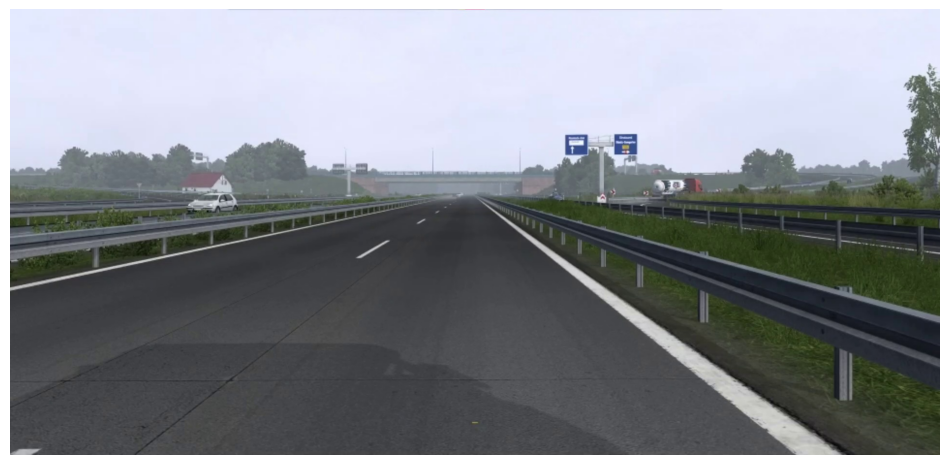

In [6]:
show(get_random_cv2_img(train_img_path), cv2_img=True)

In [8]:
get_random_cv2_img(train_img_path).shape

(920, 1920, 3)

## Define some image preprocessing

Use the same preprocessing as the Drivable Area Segmentation Notebook.

In [9]:
import numpy as np

def process_image(img): 
    # Step 1: Conditional CLAHE
    # extract luminance channel
    img_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
    luminance = img_yuv[:, :, 0]
    avg_brightness = np.mean(luminance)

    if avg_brightness < 50:
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        img_yuv[:, :, 0] = clahe.apply(img_yuv[:, :, 0])
        img_clahe = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)
    else:
        img_clahe = img.copy()

    # Step 2: Gamma Correction
    lut = np.zeros(256, dtype=np.uint8)
    for i in range(256):
        # normalize pixel value to [0, 1]
        normalized = i / 255.0
        # adaptive gamma factor (current maximum: 1.5)
        gamma = 1.0 + (1.5 - 1.0) * (1 - normalized)  # gamma decreases with brightness
        corrected = pow(normalized, 1.0 / gamma)
        lut[i] = np.clip(corrected * 255, 0, 255)
    img_bright = cv2.LUT(img, lut)


    # Step 3: Unsharp Masking
    blurred = cv2.GaussianBlur(img_bright, (0, 0), sigmaX=2)
    amount = 1.5
    return cv2.addWeighted(img_bright, 1 + amount, blurred, -amount, 0)

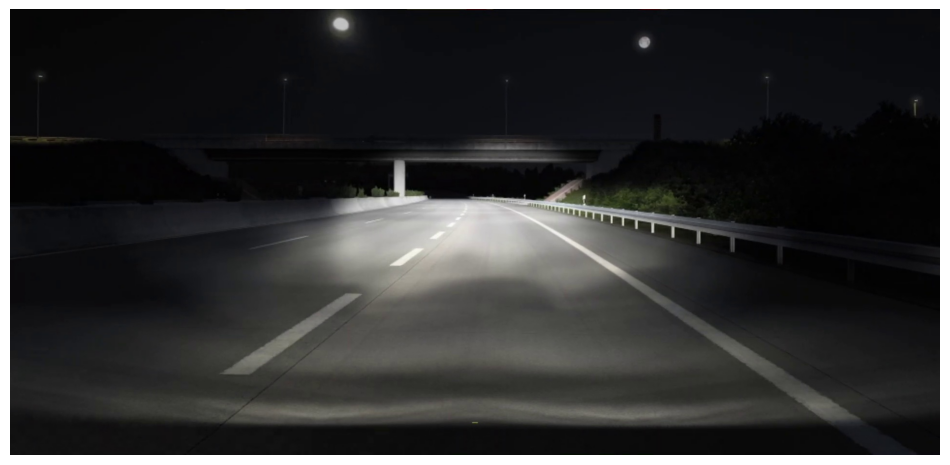

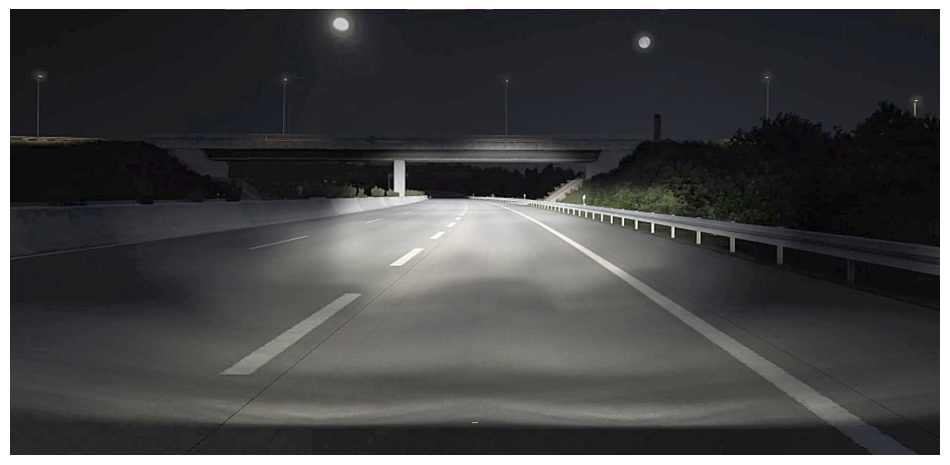

In [11]:
img = get_random_cv2_img(train_img_path)
show(img, cv2_img=True)
show(process_image(img), cv2_img=True)

## Process all files

In [12]:
train_img_path = "ets2_data_detection_04-08-2025/images/train/"

files = [f for f in os.listdir(train_img_path) if os.path.isfile(os.path.join(train_img_path, f))]

for file in files:
    filename = os.path.basename(file)
    path = os.path.join(train_img_path, filename)
    cv2.imwrite(path, process_image(cv2.imread(path)))

In [14]:
val_img_path = "ets2_data_detection_04-08-2025/images/val/"

files = [f for f in os.listdir(val_img_path) if os.path.isfile(os.path.join(val_img_path, f))]

for file in files:
    filename = os.path.basename(file)
    path = os.path.join(val_img_path, filename)
    cv2.imwrite(path, process_image(cv2.imread(path)))

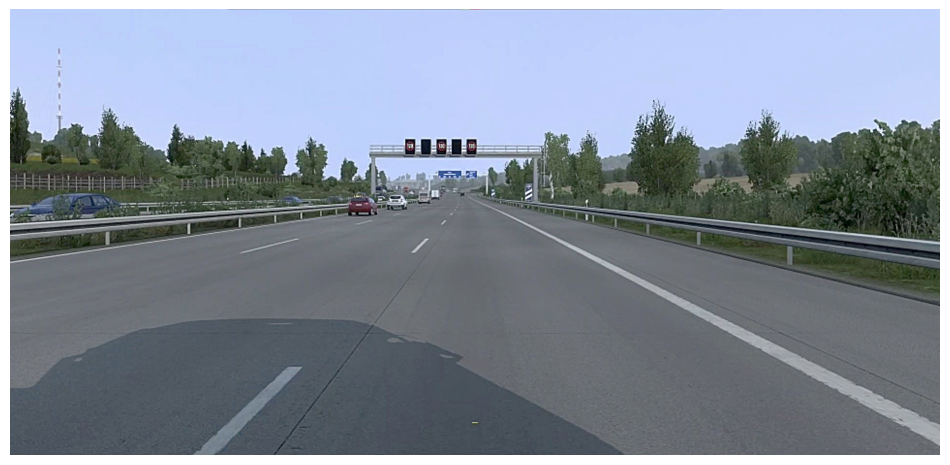

In [16]:
show(get_random_cv2_img(train_img_path), True)

## Training

In [17]:
%%capture
! pip install ultralytics

Note: There are 19 background images, so images with no boxes in them. 

In [18]:
data = "ets2_data_detection_04-08-2025/data.yaml"
! cat "ets2_data_detection_04-08-2025/data.yaml"

path: ets2_data_detection_04-08-2025/ # dataset root dir
train: images/train # train images (relative to 'path') 4 images
val: images/val # val images (relative to 'path') 4 images

# Classes
names:
  0: Sign
  1: Traffic-Light
  2: Vehicle


In [19]:
import torch

# Clear cache
torch.cuda.empty_cache()

# Optional: Collect unused memory from Python garbage collector
import gc
gc.collect()

# If using newer PyTorch and CUDA version:
torch.cuda.ipc_collect()

In [20]:
from ultralytics import YOLO
model = YOLO("yolo11m.pt")

results = model.train(data=data, batch=8, epochs=100, imgsz=(920//2, 1920//2), device=[0, 1])

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


Ultralytics 8.3.174 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
                                                        CUDA:1 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=ets2_data_detection_04-08-2025/data.yaml, degrees=0.0, deterministic=True, device=0,1, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=(460, 960), int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=Fals

Overriding model.yaml nc=80 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1      1856  ultralytics.nn.modules.conv.Conv             [3, 64, 3, 2]                 
  1                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  2                  -1  1    111872  ultralytics.nn.modules.block.C3k2            [128, 256, 1, True, 0.25]     
  3                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  4                  -1  1    444928  ultralytics.nn.modules.block.C3k2            [256, 512, 1, True, 0.25]     
  5                  -1  1   2360320  ultralytics.nn.modules.conv.Conv             [512, 512, 3, 2]              
  6                  -1  1   1380352  ultralytics.nn.modules.block.C3k2            [512, 512, 1, True]           
  7                  -1  1   2360320  ultralytics

AMP: checks passed ✅
WARNING ⚠️ updating to 'imgsz=960'. 'train' and 'val' imgsz must be an integer, while 'predict' and 'export' imgsz may be a [h, w] list or an integer, i.e. 'yolo export imgsz=640,480' or 'yolo export imgsz=640'
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2876.0±551.6 MB/s, size: 345.1 KB)
train: New cache created: /kaggle/working/ets2_data_detection_04-08-2025/labels/train.cache


train: Scanning /kaggle/working/ets2_data_detection_04-08-2025/labels/train... 136 images, 19 backgrounds, 0 corrupt: 100%|██████████| 155/155 [00:00<00:00, 1443.46it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1159.2±1127.1 MB/s, size: 545.0 KB)
val: New cache created: /kaggle/working/ets2_data_detection_04-08-2025/labels/val.cache


val: Scanning /kaggle/working/ets2_data_detection_04-08-2025/labels/val... 17 images, 0 backgrounds, 0 corrupt: 100%|██████████| 17/17 [00:00<00:00, 1359.66it/s]


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 106 weight(decay=0.0), 113 weight(decay=0.0005), 112 bias(decay=0.0)
Image sizes 960 train, 960 val
Using 4 dataloader workers
Logging results to runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      4.86G      1.347      3.993      1.043          5        960: 100%|██████████| 20/20 [00:08<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.60it/s]


                   all         17         80      0.629      0.842      0.861      0.506

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      4.92G        1.3      2.483      1.107          3        960: 100%|██████████| 20/20 [00:06<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 10.29it/s]


                   all         17         80      0.216      0.842      0.197      0.115

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      4.99G       1.31      2.045      1.124          6        960: 100%|██████████| 20/20 [00:06<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 10.05it/s]


                   all         17         80      0.508      0.507      0.505      0.286

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      5.06G      1.338       1.74      1.085         12        960: 100%|██████████| 20/20 [00:06<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 10.39it/s]


                   all         17         80      0.382      0.463      0.389      0.233

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      5.15G      1.441      1.513      1.133         18        960: 100%|██████████| 20/20 [00:06<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.61it/s]


                   all         17         80      0.185      0.529      0.236      0.126

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      5.29G      1.493      1.668      1.219         14        960: 100%|██████████| 20/20 [00:06<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.98it/s]


                   all         17         80      0.116      0.776       0.12     0.0651

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      5.38G      1.502      1.471      1.176         11        960: 100%|██████████| 20/20 [00:06<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.71it/s]


                   all         17         80    0.00852      0.218    0.00612    0.00405

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      5.52G       1.58      1.476      1.228         12        960: 100%|██████████| 20/20 [00:06<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.89it/s]


                   all         17         80      0.225      0.221      0.181       0.11

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      5.62G      1.409      1.339      1.175          5        960: 100%|██████████| 20/20 [00:06<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.64it/s]


                   all         17         80      0.341      0.556      0.273      0.169

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      5.75G      1.401      1.302      1.122         11        960: 100%|██████████| 20/20 [00:06<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 10.28it/s]


                   all         17         80      0.641      0.692      0.705      0.467

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      5.87G      1.353      1.093      1.114         12        960: 100%|██████████| 20/20 [00:06<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 10.08it/s]


                   all         17         80       0.68      0.803      0.745      0.413

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      5.98G       1.32      1.036      1.145          9        960: 100%|██████████| 20/20 [00:06<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.90it/s]


                   all         17         80      0.853      0.753      0.867      0.552

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      6.07G      1.259      1.002      1.071         28        960: 100%|██████████| 20/20 [00:07<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 10.19it/s]


                   all         17         80      0.904      0.782      0.866      0.611

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      6.21G      1.279      1.054      1.128         20        960: 100%|██████████| 20/20 [00:06<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 10.11it/s]


                   all         17         80      0.715      0.773      0.757      0.503

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100       6.3G      1.277      0.985      1.049         15        960: 100%|██████████| 20/20 [00:06<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.97it/s]


                   all         17         80      0.797      0.797      0.861      0.523

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      6.44G      1.268      1.024      1.078         19        960: 100%|██████████| 20/20 [00:06<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.83it/s]


                   all         17         80      0.842      0.852      0.899      0.625

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      6.53G      1.223     0.9486      1.059         10        960: 100%|██████████| 20/20 [00:07<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.75it/s]


                   all         17         80      0.899      0.809      0.891      0.603

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      6.67G      1.209     0.9375      1.041          8        960: 100%|██████████| 20/20 [00:07<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.71it/s]


                   all         17         80      0.868      0.855      0.881      0.617

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      6.77G      1.281     0.9821      1.079          7        960: 100%|██████████| 20/20 [00:07<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.58it/s]


                   all         17         80       0.86      0.848      0.885      0.613

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100       6.9G      1.212     0.8741      1.043          8        960: 100%|██████████| 20/20 [00:07<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.79it/s]


                   all         17         80       0.87      0.848      0.895      0.625

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      7.01G      1.168     0.8167      1.032         22        960: 100%|██████████| 20/20 [00:07<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.62it/s]


                   all         17         80      0.946      0.825      0.907      0.596

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      7.15G      1.096     0.7957     0.9909          7        960: 100%|██████████| 20/20 [00:07<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.69it/s]


                   all         17         80      0.924      0.833      0.895        0.6

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      7.24G      1.114     0.7949      1.008         19        960: 100%|██████████| 20/20 [00:07<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.76it/s]


                   all         17         80      0.927      0.827      0.894      0.578

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      7.37G      1.132     0.7851       1.01         17        960: 100%|██████████| 20/20 [00:06<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.80it/s]


                   all         17         80      0.873      0.861       0.89      0.595

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100       5.4G       1.19     0.8889      1.081         15        960: 100%|██████████| 20/20 [00:07<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.49it/s]


                   all         17         80      0.866      0.806      0.879      0.612

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100       5.4G      1.198     0.8852      1.034         10        960: 100%|██████████| 20/20 [00:06<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.86it/s]


                   all         17         80      0.804      0.864      0.871      0.566

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100       5.4G      1.157     0.7643      1.012          6        960: 100%|██████████| 20/20 [00:07<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.93it/s]


                   all         17         80      0.947      0.827       0.91      0.544

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100       5.4G       1.08     0.7806      1.009          8        960: 100%|██████████| 20/20 [00:07<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.74it/s]


                   all         17         80      0.936      0.837      0.908       0.62

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100       5.4G      1.083     0.7478      1.003         26        960: 100%|██████████| 20/20 [00:07<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.74it/s]


                   all         17         80      0.896      0.881      0.888      0.619

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100       5.4G      1.104     0.7526     0.9542         17        960: 100%|██████████| 20/20 [00:07<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.57it/s]


                   all         17         80      0.886       0.83      0.885       0.61

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      5.43G      1.102     0.7242      1.012         32        960: 100%|██████████| 20/20 [00:07<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.66it/s]


                   all         17         80       0.79      0.845      0.885      0.588

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      5.51G      1.068     0.6904      0.998         25        960: 100%|██████████| 20/20 [00:07<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.79it/s]


                   all         17         80      0.941      0.801      0.902      0.595

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      5.62G      1.069     0.7065     0.9786          8        960: 100%|██████████| 20/20 [00:07<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.86it/s]


                   all         17         80      0.911       0.85      0.897      0.594

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      5.74G      1.101     0.7104     0.9774         16        960: 100%|██████████| 20/20 [00:06<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 10.08it/s]


                   all         17         80      0.904      0.845      0.905      0.606

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      5.86G      1.069      0.672     0.9896          9        960: 100%|██████████| 20/20 [00:07<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.75it/s]


                   all         17         80      0.927      0.864      0.922      0.651

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      5.95G       1.08     0.6841     0.9611         19        960: 100%|██████████| 20/20 [00:07<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.37it/s]


                   all         17         80      0.879      0.871      0.906       0.66

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      6.06G      1.052     0.7067     0.9658         21        960: 100%|██████████| 20/20 [00:07<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.78it/s]


                   all         17         80      0.878      0.876      0.915      0.636

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      6.18G      1.053      0.702     0.9617         21        960: 100%|██████████| 20/20 [00:07<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.94it/s]


                   all         17         80      0.924      0.857      0.917      0.659

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      6.29G       1.04     0.6845      0.951         19        960: 100%|██████████| 20/20 [00:07<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.78it/s]


                   all         17         80      0.924       0.83      0.898      0.612

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      6.43G      1.027     0.8169      0.981         11        960: 100%|██████████| 20/20 [00:07<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.71it/s]


                   all         17         80      0.907      0.818      0.885      0.595

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      6.52G      1.014     0.7427      0.979          2        960: 100%|██████████| 20/20 [00:07<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 10.12it/s]


                   all         17         80      0.938       0.83      0.884      0.599

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      6.65G      1.019     0.6719     0.9674         14        960: 100%|██████████| 20/20 [00:07<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.50it/s]


                   all         17         80      0.892      0.824       0.89      0.625

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      6.75G      1.051     0.7213     0.9904         16        960: 100%|██████████| 20/20 [00:07<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.96it/s]


                   all         17         80      0.921      0.833      0.908      0.611

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100       6.9G     0.9625     0.6676     0.9743         27        960: 100%|██████████| 20/20 [00:07<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 10.02it/s]


                   all         17         80      0.911       0.84      0.913      0.632

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      6.98G     0.9844     0.6558      0.952         11        960: 100%|██████████| 20/20 [00:07<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.83it/s]


                   all         17         80      0.934      0.842      0.904      0.625

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100       7.1G     0.8822     0.6225     0.8822          0        960: 100%|██████████| 20/20 [00:07<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.94it/s]


                   all         17         80      0.949      0.855      0.897      0.613

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100       7.2G     0.9729     0.6924     0.9617          3        960: 100%|██████████| 20/20 [00:07<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.63it/s]


                   all         17         80      0.911      0.867      0.904      0.628

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      7.33G      1.022      0.668     0.9852         17        960: 100%|██████████| 20/20 [00:07<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.89it/s]


                   all         17         80      0.902       0.87      0.913      0.616

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      7.43G     0.9332     0.6119     0.9443         12        960: 100%|██████████| 20/20 [00:07<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.95it/s]


                   all         17         80      0.964      0.874       0.93      0.647

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      5.45G      0.954     0.6219     0.9555          9        960: 100%|██████████| 20/20 [00:07<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.87it/s]


                   all         17         80       0.95      0.882      0.933      0.668

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      5.45G     0.9375     0.5875     0.9206         18        960: 100%|██████████| 20/20 [00:07<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.91it/s]


                   all         17         80      0.926      0.876      0.921      0.631

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      5.45G      1.001     0.6048     0.9161         22        960: 100%|██████████| 20/20 [00:07<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.74it/s]


                   all         17         80      0.923      0.864      0.912       0.62

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      5.45G     0.9288      0.582     0.9208         14        960: 100%|██████████| 20/20 [00:07<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.90it/s]


                   all         17         80      0.946      0.871      0.918      0.605

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      5.45G      0.894     0.5529     0.9133          6        960: 100%|██████████| 20/20 [00:07<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.84it/s]


                   all         17         80      0.907      0.887      0.913      0.631

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      5.45G     0.9234     0.5773     0.9241         27        960: 100%|██████████| 20/20 [00:07<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.64it/s]


                   all         17         80      0.944       0.88      0.921      0.643

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      5.52G     0.9229     0.5899     0.9421         40        960: 100%|██████████| 20/20 [00:07<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.81it/s]


                   all         17         80      0.966      0.868      0.921      0.657

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      5.63G     0.9338       0.59     0.9378          6        960: 100%|██████████| 20/20 [00:07<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.70it/s]


                   all         17         80      0.891      0.864      0.912      0.633

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      5.73G     0.9128     0.5935     0.9548          3        960: 100%|██████████| 20/20 [00:07<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.84it/s]


                   all         17         80      0.888      0.888      0.923      0.638

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      5.84G     0.9191     0.5865     0.9549          1        960: 100%|██████████| 20/20 [00:07<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.80it/s]


                   all         17         80      0.944      0.867      0.924      0.675

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      5.96G      0.884     0.5592      0.929         26        960: 100%|██████████| 20/20 [00:07<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.80it/s]


                   all         17         80       0.93       0.91       0.92      0.655

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      6.06G     0.9378     0.6146     0.9536         16        960: 100%|██████████| 20/20 [00:07<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.33it/s]


                   all         17         80      0.938      0.867      0.925       0.66

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      6.18G     0.8615     0.5518     0.9087          7        960: 100%|██████████| 20/20 [00:07<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.75it/s]


                   all         17         80       0.96      0.842      0.915      0.637

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      6.29G     0.8322      0.519     0.8944         10        960: 100%|██████████| 20/20 [00:07<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.74it/s]


                   all         17         80      0.966      0.865      0.928       0.64

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      6.42G     0.8528     0.5195      0.905         25        960: 100%|██████████| 20/20 [00:07<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.65it/s]


                   all         17         80      0.918      0.888      0.929      0.656

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      6.51G     0.8703     0.5625     0.9005         26        960: 100%|██████████| 20/20 [00:07<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.92it/s]


                   all         17         80      0.944      0.876      0.927      0.655

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      6.64G     0.8866     0.5233     0.8995         11        960: 100%|██████████| 20/20 [00:07<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 10.07it/s]


                   all         17         80      0.918      0.887      0.929      0.662

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      6.75G     0.8191     0.5041     0.8859         26        960: 100%|██████████| 20/20 [00:07<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.89it/s]


                   all         17         80       0.89      0.891      0.923      0.669

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      6.89G     0.8205     0.5089     0.9315          8        960: 100%|██████████| 20/20 [00:07<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.63it/s]


                   all         17         80      0.941      0.885       0.92      0.652

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      6.98G     0.8101     0.4878     0.9134         21        960: 100%|██████████| 20/20 [00:07<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.64it/s]


                   all         17         80      0.957      0.887      0.923      0.653

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      7.11G     0.8772     0.5244     0.9342          2        960: 100%|██████████| 20/20 [00:07<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.92it/s]


                   all         17         80      0.941      0.884      0.925      0.636

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      7.21G     0.8623     0.5219      0.894         23        960: 100%|██████████| 20/20 [00:07<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 10.13it/s]


                   all         17         80      0.945      0.888      0.926      0.638

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      7.33G     0.8425     0.5157     0.9031         15        960: 100%|██████████| 20/20 [00:07<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.85it/s]


                   all         17         80      0.949      0.894      0.935      0.657

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      7.44G     0.7997     0.4906     0.8679          9        960: 100%|██████████| 20/20 [00:07<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.73it/s]


                   all         17         80      0.929      0.877      0.927      0.643

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      5.45G     0.8062     0.4948     0.8886          6        960: 100%|██████████| 20/20 [00:07<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 10.21it/s]


                   all         17         80      0.909      0.884      0.921      0.649

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      5.45G     0.7907     0.4609      0.888         23        960: 100%|██████████| 20/20 [00:07<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.44it/s]


                   all         17         80      0.938      0.883      0.926      0.657

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      5.45G       0.78     0.4639     0.8803         10        960: 100%|██████████| 20/20 [00:07<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.69it/s]


                   all         17         80       0.94      0.889      0.931       0.67

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      5.45G     0.8615      0.492     0.9163          6        960: 100%|██████████| 20/20 [00:07<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.81it/s]


                   all         17         80      0.939      0.876      0.922      0.647

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      5.45G     0.7628     0.4533     0.8843         10        960: 100%|██████████| 20/20 [00:07<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 10.12it/s]


                   all         17         80      0.949      0.873      0.916      0.656

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      5.46G     0.8479     0.4992     0.8915         10        960: 100%|██████████| 20/20 [00:07<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.65it/s]


                   all         17         80      0.957      0.855      0.915      0.658

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      5.53G     0.7698     0.4589     0.8859         28        960: 100%|██████████| 20/20 [00:07<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.95it/s]


                   all         17         80      0.968       0.86       0.92      0.672

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      5.61G     0.7068       0.43     0.8611         13        960: 100%|██████████| 20/20 [00:07<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 10.00it/s]


                   all         17         80       0.96      0.862      0.923      0.672

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      5.72G     0.7643     0.5152     0.8565          1        960: 100%|██████████| 20/20 [00:07<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.90it/s]


                   all         17         80      0.962      0.851      0.919       0.67

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      5.84G     0.7239     0.4247     0.8634          8        960: 100%|██████████| 20/20 [00:07<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 10.01it/s]


                   all         17         80      0.953      0.851      0.911      0.635

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      5.97G     0.7349     0.4331     0.8417         16        960: 100%|██████████| 20/20 [00:07<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 10.03it/s]


                   all         17         80      0.929      0.873      0.913      0.643

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      6.06G     0.7311     0.4313     0.8863          2        960: 100%|██████████| 20/20 [00:07<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.63it/s]


                   all         17         80      0.971      0.867      0.937      0.677

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      6.19G       0.67     0.4258     0.8624         15        960: 100%|██████████| 20/20 [00:07<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.75it/s]


                   all         17         80      0.966      0.857      0.934      0.669

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      6.28G     0.7561     0.4471     0.8712         10        960: 100%|██████████| 20/20 [00:07<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.72it/s]


                   all         17         80      0.917      0.861      0.912      0.647

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100       6.4G     0.7292      0.424     0.8696          3        960: 100%|██████████| 20/20 [00:07<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.93it/s]


                   all         17         80      0.943      0.848      0.911      0.638

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      6.51G     0.7437     0.4618     0.8745         19        960: 100%|██████████| 20/20 [00:07<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 10.04it/s]


                   all         17         80      0.936      0.871      0.924      0.633

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      6.65G     0.7312     0.4267     0.8572         24        960: 100%|██████████| 20/20 [00:07<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 10.06it/s]


                   all         17         80      0.948      0.868      0.927      0.641
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      6.74G     0.7902     0.4616     0.8809          6        960: 100%|██████████| 20/20 [00:07<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.94it/s]


                   all         17         80      0.962      0.864      0.927      0.649

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      6.86G     0.7487     0.4393     0.8595          6        960: 100%|██████████| 20/20 [00:06<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.70it/s]


                   all         17         80      0.959      0.863      0.929       0.65

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      6.97G     0.6979     0.4015     0.8734          2        960: 100%|██████████| 20/20 [00:07<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 10.02it/s]


                   all         17         80      0.947       0.87      0.932      0.666

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100       7.1G     0.7233     0.4208     0.8549          3        960: 100%|██████████| 20/20 [00:06<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.61it/s]


                   all         17         80       0.95      0.866      0.925      0.673

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      7.19G     0.6686     0.4072     0.8481          6        960: 100%|██████████| 20/20 [00:07<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.78it/s]


                   all         17         80      0.939       0.86      0.924       0.66

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      7.31G     0.6603      0.398     0.8454          5        960: 100%|██████████| 20/20 [00:06<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.72it/s]


                   all         17         80       0.94      0.857      0.927      0.653

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      7.42G     0.6265     0.3746     0.8419          9        960: 100%|██████████| 20/20 [00:07<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.85it/s]


                   all         17         80      0.922      0.875      0.927      0.651

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100       5.4G      0.644       0.37     0.8434         11        960: 100%|██████████| 20/20 [00:07<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.97it/s]


                   all         17         80      0.931      0.877       0.93      0.635

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100       5.4G     0.6955     0.4076     0.8446          7        960: 100%|██████████| 20/20 [00:07<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.93it/s]


                   all         17         80      0.955      0.851      0.916      0.643

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100       5.4G     0.6815     0.3951     0.8597          7        960: 100%|██████████| 20/20 [00:06<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 10.07it/s]


                   all         17         80      0.957      0.855      0.917      0.655

100 epochs completed in 0.226 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 40.5MB
Optimizer stripped from runs/detect/train/weights/best.pt, 40.5MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.174 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
                                                        CUDA:1 (Tesla T4, 15095MiB)
YOLO11m summary (fused): 125 layers, 20,032,345 parameters, 0 gradients, 67.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.46it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all         17         80      0.971      0.868      0.937      0.674
                  Sign         11         22          1      0.924       0.96       0.67
         Traffic-Light          1          3      0.964          1      0.995      0.768
               Vehicle         16         55      0.949      0.678      0.855      0.584
Speed: 0.9ms preprocess, 16.0ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs/detect/train


## Test

In [21]:
%%capture
! wget "https://arcxyon.com/wp-content/uploads/2025/08/Raw_Examples_04-08-2025.zip"
! unzip "Raw_Examples_04-08-2025.zip"

In [22]:
example_img_path = "67/"

In [23]:
def get_road_objects(img):
    # use model.predict on specific device when having multiple gpus
    results = model.predict(img, device='cuda:0', batch=1)
    
    # assuming only one image processed per call
    for result in results:
        xyxy = result.boxes.xyxy  # [x1, y1, x2, y2]
        class_ids = result.boxes.cls.int()
        confs = result.boxes.conf
        names = [result.names[cls.item()] for cls in class_ids]

        for i, box in enumerate(xyxy):
            x1, y1, x2, y2 = map(int, box.tolist())
            label = f"{names[i]} {confs[i]:.2f}"

            # Draw bounding box
            cv2.rectangle(img, (x1, y1), (x2, y2), color=(0, 0, 255), thickness=2)

            # Put label above the bounding box
            cv2.putText(
                img,
                label,
                (x1, y1 - 10),
                fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                fontScale=0.5,
                color=(0, 0, 255),
                thickness=1
            )
    return img


0: 480x960 3 Signs, 4 Vehicles, 47.7ms
Speed: 5.8ms preprocess, 47.7ms inference, 188.1ms postprocess per image at shape (1, 3, 480, 960)


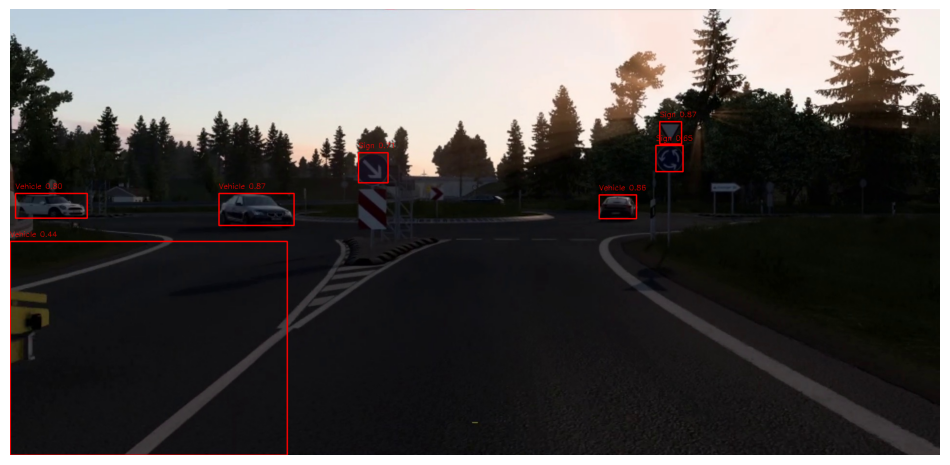

In [24]:
img_name = get_random_cv2_img(example_img_path, True)
img_path = os.path.join(example_img_path, img_name)
img = cv2.imread(img_path)

show(get_road_objects(img), cv2_img=True)